# VIZBI Tutorial Session
### Part 2: Cytoscape, IPython, Docker, and reproducible network data visualization workflows

Tuesday, 3/24/2015


### Lesson 2: Working with Graph Libraries

by [Keiichiro Ono](http://keiono.github.io/)

----

![](http://cl.ly/XohP/logo300.png) 

![](http://igraph.org/img/igraph3.svg)


## Background 
Cytoscape is an all-in-one package for network data integration, analysys, and visualization.  However, there are several powerful graph abnalysis tools designed for advanced users.  They usually have command-line interface and are not easy to use for interactive data visualization.  __By using cyREST, you can access the best of the two worlds!__

### Cytoscape vs Other Graph Libraries

#### Cytoscape

![](http://www.cytoscape.org/images/logo/cy3logoOrange.svg)

##### Pros
* Easy-to-use GUI
* All-in-one
* Advanced visualization features

##### Cons
* GUI operation...
    * Not easy to integrate it into automated workflows
* Scalability
    * Designed to run on workstations

#### Command-Line Graph Analysis Tools

![](http://igraph.org/img/igraph3.svg)

##### Pros
* Lots of graph analysis algorithms
* High performance
    * Not always true, but some of them use C/C++ modules for optimization

##### Cons
* Limited visualization features
* Hard to use for people with limited computing literacy

## Use Cytoscape as an external visualization engine
In this section, you will learn the following:

* Load network data sets to NetworkX graph object
* Calculate basic statistics of the graph
* Visualize it in Cytoscape

----

## Overview of Popular Graph Libraries

### NetworkX
One of the most popular graph analysis library in Python community.  It is easy to install, but a bit slower than the other two.

### igraph
Very popular library in R programmers, but also available for Python.  Lots of graph analysis functions and popular in social network analysis community.

### Graph-Tool
In most cases, this is the fastest graph analysis library.  Optimization is done by calling external [Boost C++ library](http://www.boost.org/doc/libs/1_57_0/libs/graph/doc/table_of_contents.html). 

In this container, all of these three are installed and ready to use!


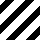
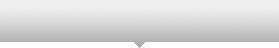
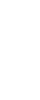
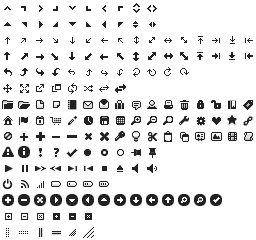
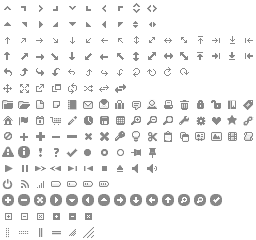
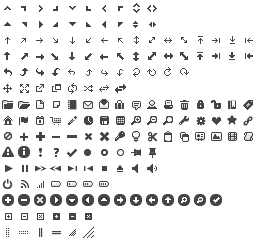
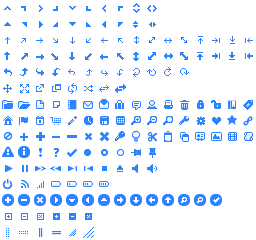
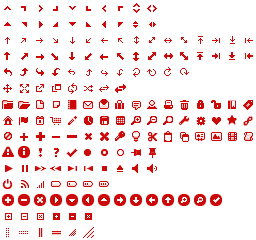
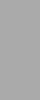
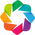
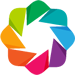
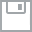
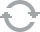
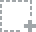
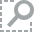
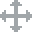
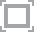
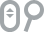

---
Name: py2cytoscape
Version: 0.3.0
Location: /usr/local/lib/python3.4/dist-packages
Requires: 


In [1]:
import requests
import json
import networkx as nx
from IPython.display import Image

from py2cytoscape import util as cy 

from collections import OrderedDict
import numpy as np
from bokeh.charts import Bar
from bokeh.plotting import *

import matplotlib.pyplot as plt
%matplotlib inline

output_notebook()

import pandas as pd

PORT_NUMBER = 1234
IP = '137.110.137.158'
BASE = 'http://' + IP +  ':' + str(PORT_NUMBER) + '/v1/'
HEADERS = {'Content-Type': 'application/json'}

# Start from a clean slate!
requests.delete(BASE + 'session')

!pip show py2cytoscape

## Load a sample JSON network from file

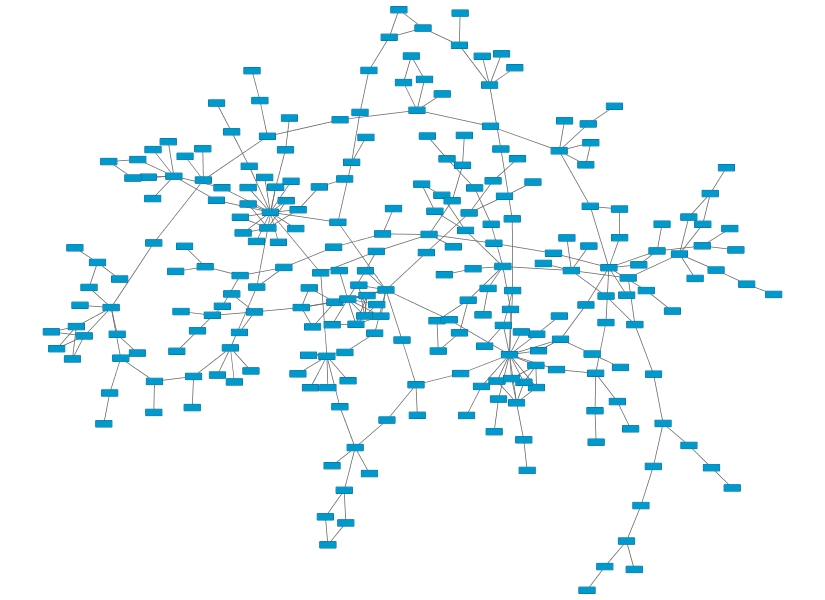

In [2]:
# Create dictionary object from JSON file
f = open('data/yeast.json', 'r')
cyjs_network = json.load(f)

# Set network name
cyjs_network['data']['name'] = 'Yeast Sample 1' 

res = requests.post(BASE + 'networks', data=json.dumps(cyjs_network), headers=HEADERS)
new_suid = res.json()['networkSUID']

# Apply style and layout
requests.get(BASE + 'apply/layouts/force-directed/' + str(new_suid))
requests.get(BASE + 'apply/styles/default/' + str(new_suid))

Image(BASE+'networks/' + str(new_suid) + '/views/first.png')

## Data Round-Trip between Cytoscape and NetworkX
Basic data exchange format for cyREST is Cytoscape.js JSON.  To use objects in Cytoscape.js JSON format in other network libraries, we need to write a converter code for data rounndtrip. 

### py2cytoscape
This is still an ongoing project, but we are developing utility library named __py2cytoscape__ which includes data conversion utilities and other usiful functions for Python users.  Aa of today (March 2015), data roundtrip between Cytoscape,js JSOB and NetworkX is supported.

Here is the simplest example:

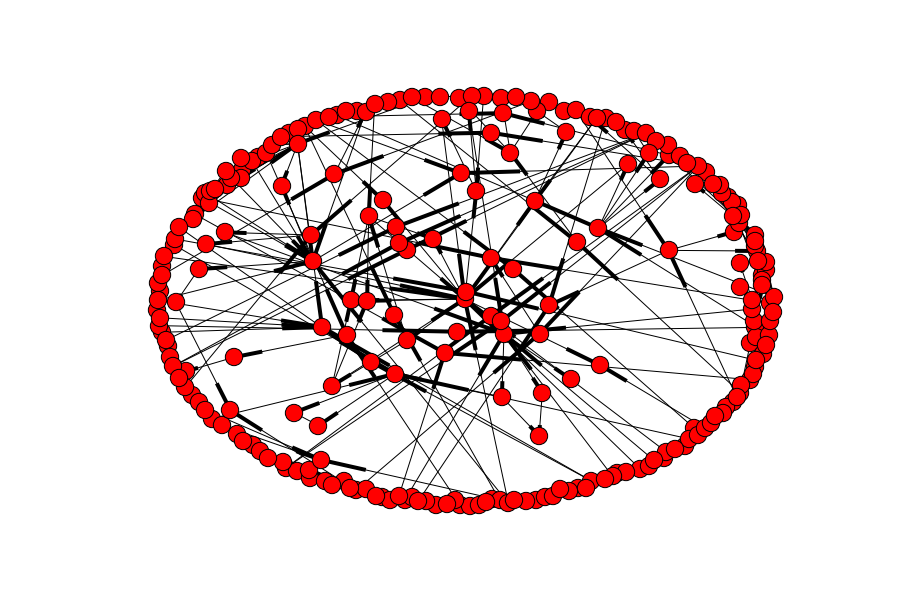

In [3]:
# Convert Python dictionary in Cytoscape.js format into NetworkX object
nx_network = cy.to_networkx(cyjs_network)

# Draw it with NetworkX renderer 
plt.figure(figsize=(12,8));
nx.draw_spring(nx_network)

Well, now you can see why we want to use Cytoscape as an external rendering engine...

### Generate graph with NetworkX
NetworkX has many graph generators.  It is usuful when you need to create some random graphs for statistical analysis.  Let's learn how to use some of the generators.

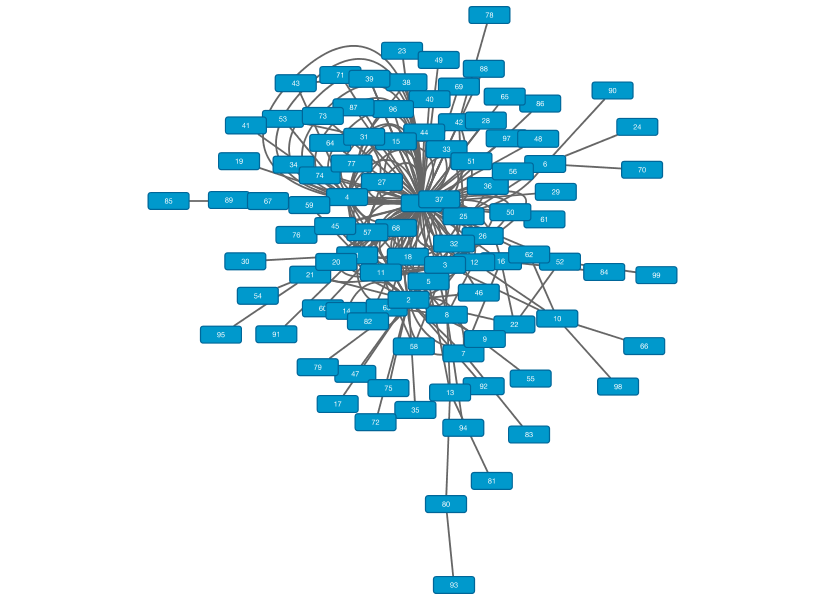

In [4]:
# Generate graphs with NetworkX

# Scale-Free graph wiht 100 nodes (Directed)
scale_free_graph = nx.scale_free_graph(100)
scale_free_graph.graph['name'] = 'Scale-Free Graph'
mst = nx.minimum_spanning_tree(scale_free_graph.to_undirected())

# Convert it into Cytoscape.js format

def post_nx(nx_graph, layout='force-directed'):
    # Convert into Cytoscape.js JSON
    cyjs_network = cy.from_networkx(nx_graph)
    # POST it!
    res = requests.post(BASE + 'networks', data=json.dumps(cyjs_network), headers=HEADERS)
    suid = res.json()['networkSUID']
    requests.get(BASE + 'apply/layouts/' + layout + '/' + str(suid))
    return Image(url=BASE+'networks/' + str(suid) + '/views/first.png', embed=True)

network_images = []
network_images.append(post_nx(scale_free_graph))
network_images[0]

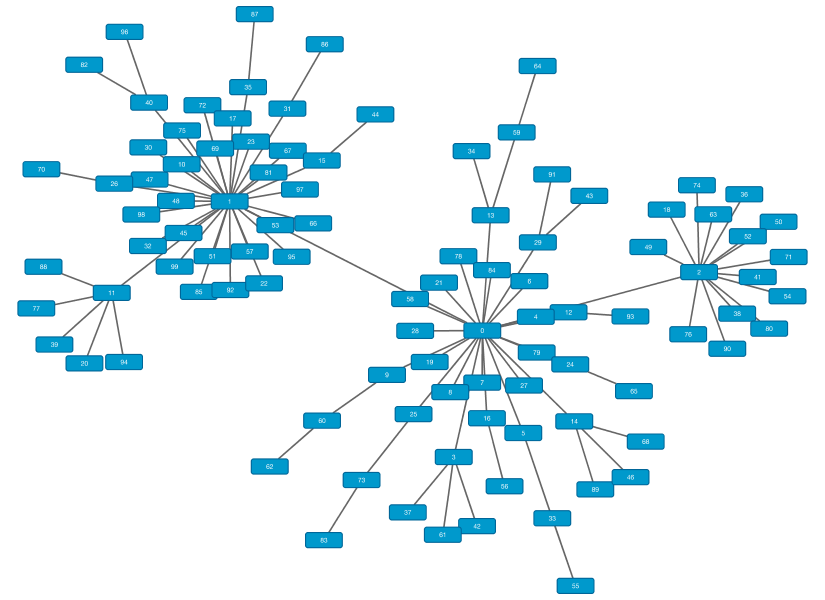

In [5]:
post_nx(mst)    

In [6]:
# ...And other graph generators

graphs = {}
NUMBER_OF_NODES = 100

# Add Converted Cytoscape network
graphs['yeast'] = nx_network

# Complete
graphs['complete'] = nx.complete_graph(NUMBER_OF_NODES)

# Circular Ladder
graphs['circular ladder'] = nx.circular_ladder_graph(NUMBER_OF_NODES)

# Binominal
graphs['binominal'] = nx.binomial_graph(NUMBER_OF_NODES, 0.3)

## Calculate some basic statistics with NetworkX

In [7]:
for key in graphs.keys():
    g = graphs[key]
    # Perform simple graph analysis
    
    # Node statistics
    bc = nx.betweenness_centrality(g)
    degree = nx.degree(g)
    cc = nx.closeness_centrality(g)
#     mst = nx.minimum_spanning_tree(g.to_undirected())
    nx.set_node_attributes(g, 'betweenness', bc)
    nx.set_node_attributes(g, 'closeness', cc)
    nx.set_node_attributes(g, 'degree', degree)
    
    # Network statistics
    g.graph["avg_shortest_path_len"] = nx.average_shortest_path_length(g)
    g.graph["density"] = nx.density(g)
    network_images.append(post_nx(g, 'circular'))

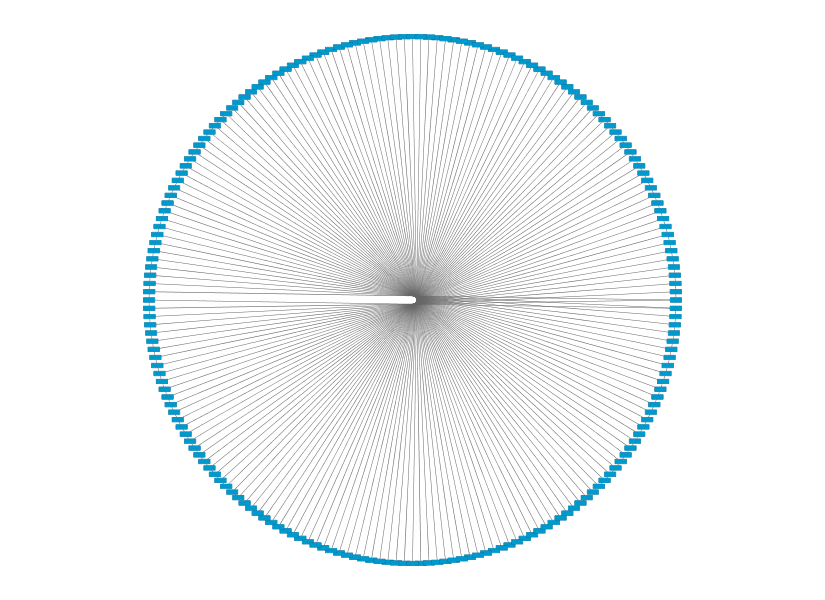

In [8]:
network_images[4]

## Use libraries as file format converter
Cytoscape supports many standard graph file formats, including GML, GraphML, or XGMML, but there several more standad formats like DOT used in Graphviz.  You can use graph-tools and other libraries as a data converter.

### DOT to GraphML

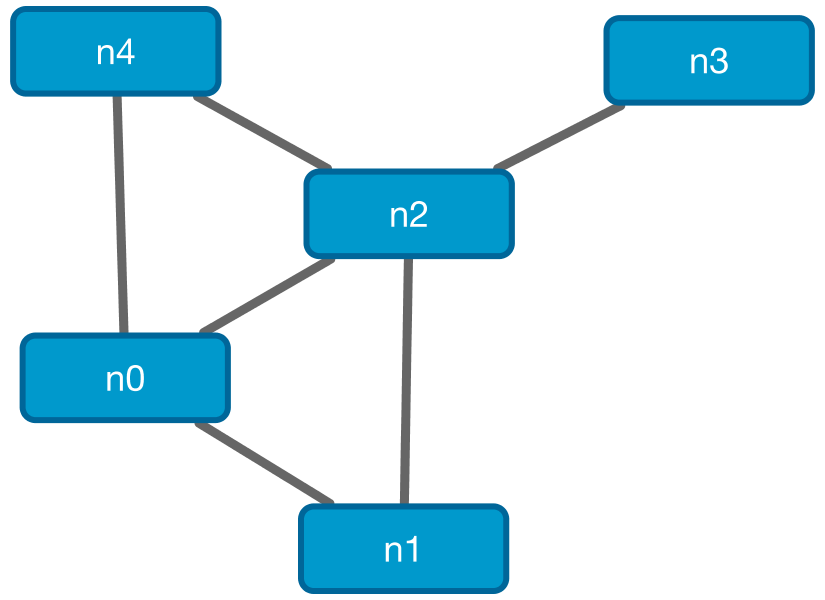

In [9]:
import graph_tool as gt
import graph_tool.collection as collection

dot_graph = gt.load_graph('data/sample.dot')
dot_graph.save('data/sample.graphml', fmt='graphml')

def create_from_list(network_list):
    payload = {'source': 'url', 'collection': 'Dot Sample'}
    server_res = requests.post(BASE + 'networks', data=json.dumps(network_list), headers=HEADERS, params=payload)
    return server_res.json()
 
network_file = 'file:////Users/kono/prog/git/vizbi-2015/tutorials/data/sample.graphml'
id_json = create_from_list([network_file])

# Apply layout
suid = id_json[0]['networkSUID'][0]
requests.get(BASE + 'apply/layouts/force-directed/' + str(suid))
Image(url=BASE+'networks/' + str(suid) + '/views/first.png', embed=True)

## Use igraph for network analysis

In [10]:
import igraph

gal= igraph.Graph.Read_GML('data/galFiltered.gml')
dend = gal.community_edge_betweenness()

clusters = dend.as_clustering()
gal.vs['clusters'] = clusters.membership

df = pd.DataFrame(gal.vs['clusters'], gal.vs['label'], columns=['cluster'])
df.to_csv('data/clusters.txt')
df.head(10)

,cluster
YKR026C,0
YGL122C,0
YMR146C,1
YDR429C,1
YFL017C,1
YOL123W,2
YGL044C,2
YGR203W,1
YIL061C,1
YCR084C,1


### Homework: Visualize the clusters in Cytoscape

## Data mangling with Pandas

### What is Pandas?
[Pandas]() is a standard library in Python data scientists community.  It provids several data structures and functions for data preparation and analysis.  It is a fairly large library with a lot of features and we do not have enough time to cover all feattures.  There is a great book written by the author of the library.  If you are intereted in Pandas, please read the following book:

* Python Data Analysis

### Using DataFrame for Data Editing and Conversions

In [11]:
df1 = pd.read_csv('http://www.ebi.ac.uk/Tools/webservices/psicquic/intact/webservices/current/search/query/brca*?format=tab27', 
                  delimiter='\t', header=None)
df1.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,uniprotkb:Q9Y385,uniprotkb:P38398,intact:EBI-988826|uniprotkb:Q53F25|uniprotkb:A...,intact:EBI-349905|uniprotkb:Q1RMC1|uniprotkb:Q...,psi-mi:ub2j1_human(display_long)|uniprotkb:Non...,psi-mi:brca1_human(display_long)|uniprotkb:BRC...,"psi-mi:""MI:0397""(two hybrid array)",-,imex:IM-9597|pubmed:19690564,taxid:9606(human)|taxid:9606(Homo sapiens),...,rogid:nc3+V3Qxy1ZDhTWgTPLakJukxPM9606,rogid:Tx+5uS8dERqc0lhPZ0ZIKQaifXM9606,intact-crc:88DA48E32D6776A3|rigid:EBTmW/sLTONK...,False,-,-,-,-,"psi-mi:""MI:0396""(predetermined participant)","psi-mi:""MI:0396""(predetermined participant)"
1,uniprotkb:Q5VVX9,uniprotkb:Q99728,intact:EBI-2130181|uniprotkb:Q8N1D4,intact:EBI-473181|uniprotkb:F6MDH9|uniprotkb:F...,psi-mi:ube2u_human(display_long)|uniprotkb:UBE...,psi-mi:bard1_human(display_long)|uniprotkb:BAR...,"psi-mi:""MI:0397""(two hybrid array)",-,imex:IM-9597|pubmed:19690564,taxid:9606(human)|taxid:9606(Homo sapiens),...,rogid:onw4DUslrZLhQZp8FtqY6s6Q/u09606,rogid:5dT1T3GUceuvwPpiTv5QW/QEDgE9606,intact-crc:35FBF5E49A9671E0|rigid:EvuHsiDjMeWq...,False,-,-,-,-,"psi-mi:""MI:0396""(predetermined participant)","psi-mi:""MI:0396""(predetermined participant)"
2,uniprotkb:Q06609,uniprotkb:P51587,intact:EBI-297202|intact:EBI-1059207|uniprotkb...,intact:EBI-79792|uniprotkb:Q13879|uniprotkb:O1...,psi-mi:rad51_human(display_long)|uniprotkb:RAD...,psi-mi:brca2_human(display_long)|uniprotkb:BRC...,"psi-mi:""MI:0413""(electrophoretic mobility shif...",Carreira et al. (2009),pubmed:19303847|imex:IM-20288,taxid:9606(human)|taxid:9606(Homo sapiens),...,rogid:B7WPMU7tZuNcA2qjsTR+7i/OwFw9606,rogid:UcdngwpTSS6hG/pvQGgpp40u67I9606,intact-crc:72C657CC1BAB693B,False,-,mutation decreasing interaction:1526-1526|glut...,-,-,"psi-mi:""MI:0821""(molecular weight estimation b...","psi-mi:""MI:0821""(molecular weight estimation b..."
3,uniprotkb:Q06609,uniprotkb:P51587,intact:EBI-297202|intact:EBI-1059207|uniprotkb...,intact:EBI-79792|uniprotkb:Q13879|uniprotkb:O1...,psi-mi:rad51_human(display_long)|uniprotkb:RAD...,psi-mi:brca2_human(display_long)|uniprotkb:BRC...,"psi-mi:""MI:0413""(electrophoretic mobility shif...",Carreira et al. (2009),pubmed:19303847|imex:IM-20288,taxid:9606(human)|taxid:9606(Homo sapiens),...,rogid:B7WPMU7tZuNcA2qjsTR+7i/OwFw9606,rogid:UcdngwpTSS6hG/pvQGgpp40u67I9606,intact-crc:29B545670D1E5C62,False,-,mutation decreasing interaction:1526-1526|glut...,-,-,"psi-mi:""MI:0821""(molecular weight estimation b...","psi-mi:""MI:0821""(molecular weight estimation b..."
4,uniprotkb:Q06609,uniprotkb:P51587,intact:EBI-297202|intact:EBI-1059207|uniprotkb...,intact:EBI-79792|uniprotkb:Q13879|uniprotkb:O1...,psi-mi:rad51_human(display_long)|uniprotkb:RAD...,psi-mi:brca2_human(display_long)|uniprotkb:BRC...,"psi-mi:""MI:0413""(electrophoretic mobility shif...",Carreira et al. (2009),pubmed:19303847|imex:IM-20288,taxid:9606(human)|taxid:9606(Homo sapiens),...,rogid:B7WPMU7tZuNcA2qjsTR+7i/OwFw9606,rogid:UcdngwpTSS6hG/pvQGgpp40u67I9606,intact-crc:FDB2287FC7FF8835,False,-,necessary binding region:1525-1530,-,-,"psi-mi:""MI:0821""(molecular weight estimation b...","psi-mi:""MI:0821""(molecular weight estimation b..."


In [12]:
brca_df = pd.DataFrame()
brca_df['source'] = df1[0]
brca_df['target'] = df1[1]
brca_df.head()

,source,target
0,uniprotkb:Q9Y385,uniprotkb:P38398
1,uniprotkb:Q5VVX9,uniprotkb:Q99728
2,uniprotkb:Q06609,uniprotkb:P51587
3,uniprotkb:Q06609,uniprotkb:P51587
4,uniprotkb:Q06609,uniprotkb:P51587


### Functional Style Coding
This is a bit beyond scope of this tutorial, but it is a good idea to use functional style coding when manipulating data objects instead of writing a lot of for loops.

In [13]:
brca_df['source_uniprot'] = brca_df['source'].apply(lambda x: x.split(':', 1)[1])
brca_df['target_uniprot'] = brca_df['target'].apply(lambda x: x.split(':', 1)[1])

brca_df.head(10)

,source,target,source_uniprot,target_uniprot
0,uniprotkb:Q9Y385,uniprotkb:P38398,Q9Y385,P38398
1,uniprotkb:Q5VVX9,uniprotkb:Q99728,Q5VVX9,Q99728
2,uniprotkb:Q06609,uniprotkb:P51587,Q06609,P51587
3,uniprotkb:Q06609,uniprotkb:P51587,Q06609,P51587
4,uniprotkb:Q06609,uniprotkb:P51587,Q06609,P51587
5,uniprotkb:Q06609,uniprotkb:P51587,Q06609,P51587
6,"chebi:""CHEBI:15422""",uniprotkb:P51587,"""CHEBI:15422""",P51587
7,"chebi:""CHEBI:15422""",uniprotkb:P51587,"""CHEBI:15422""",P51587
8,"chebi:""CHEBI:15422""",uniprotkb:P51587,"""CHEBI:15422""",P51587
9,"chebi:""CHEBI:15422""",uniprotkb:P51587,"""CHEBI:15422""",P51587


### Generate graphs

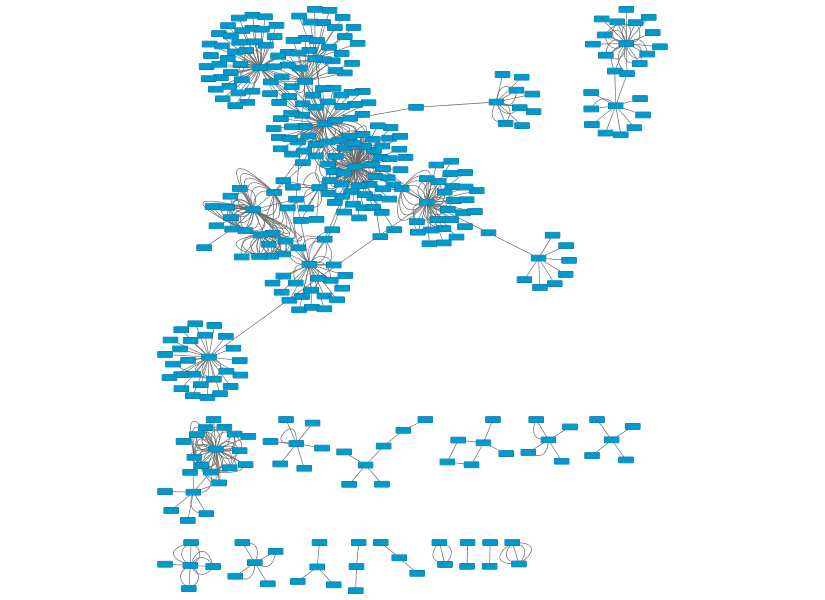

In [14]:
# Small function to create NetworkX graph from DataFrame
net = nx.MultiGraph()

for i in range(len(brca_df)):
    row = brca_df.ix[i]
    source = net.add_node(row['source_uniprot'])
    target = net.add_node(row['target_uniprot'])
    net.add_edge(row['source_uniprot'], row['target_uniprot'])

res = requests.post(BASE + 'networks', data=json.dumps(cy.from_networkx(net)), headers=HEADERS)
suid = res.json()['networkSUID']

requests.get(BASE + 'apply/layouts/force-directed/' + str(suid))
Image(url=BASE+'networks/' + str(suid) + '/views/first.png', embed=True)

In [15]:
# Generate a unique list of nodes
node_table = pd.DataFrame(net.nodes(), columns=['name'])

# Assign type for CHEBI nodes
node_table['type'] = node_table['name'].apply(lambda x: 'compound' if 'CHEBI' in x else 'protein')
node_table.head(10)

,name,type
0,Q4VCS5,protein
1,Q81TW1,protein
2,P48149,protein
3,Q9Y3C5,protein
4,O75486,protein
5,Q8CIH5,protein
6,O43583,protein
7,O00410,protein
8,P49840,protein
9,EBI-539895,protein


In [16]:
nodes_url = BASE + 'networks/' + str(suid) + '/tables/defaultnode'
print(nodes_url)
df_nodes = pd.DataFrame(requests.get(nodes_url).json()['rows'])
df_nodes.head()

http://137.110.137.158:1234/v1/networks/78314/tables/defaultnode


,SUID,id,name,selected,shared_name
0,78324,Q4VCS5,Q4VCS5,False,Q4VCS5
1,78325,Q81TW1,Q81TW1,False,Q81TW1
2,78326,P48149,P48149,False,P48149
3,78327,Q9Y3C5,Q9Y3C5,False,Q9Y3C5
4,78328,O75486,O75486,False,O75486


In [17]:
merged = df_nodes.merge(node_table, on='name')
merged.head(10)

,SUID,id,name,selected,shared_name,type
0,78324,Q4VCS5,Q4VCS5,False,Q4VCS5,protein
1,78325,Q81TW1,Q81TW1,False,Q81TW1,protein
2,78326,P48149,P48149,False,P48149,protein
3,78327,Q9Y3C5,Q9Y3C5,False,Q9Y3C5,protein
4,78328,O75486,O75486,False,O75486,protein
5,78329,Q8CIH5,Q8CIH5,False,Q8CIH5,protein
6,78330,O43583,O43583,False,O43583,protein
7,78331,O00410,O00410,False,O00410,protein
8,78332,P49840,P49840,False,P49840,protein
9,78333,EBI-539895,EBI-539895,False,EBI-539895,protein


## Add Table Data to Existing Network

In [ ]:
# First, create new column
type_column = {
    'name' : 'type',
    'type' : 'String'
}
requests.post(BASE + 'networks/' + str(suid) + '/tables/defaultnode/columns', data=json.dumps(type_column), headers=HEADERS)


def append_new_value(row, new_values):
    new_val ={
        'SUID': row['SUID'],
        'value' : row['type']
    }
    new_values.append(new_val)
    
values = []
merged.apply(lambda row: append_new_value(row, values), axis=1)

# Now update it!
requests.put(BASE + 'networks/' + str(suid) + '/tables/defaultnode/columns/type', data=json.dumps(values), headers=HEADERS)

<Response [200]>

Now you can use new values under ___type___ column to create new visualization.  Actual visualization code examples will be discussed in the next lesson, but here is an example:


![](http://cl.ly/aMb5/cyrest-lesson2-1.png)


----


### Use layout algorithms in graph-tool

In [ ]:
import graph_tool.community as community
import graph_tool.draw as draw

g = gt.load_graph('data/galFiltered.gml')

pos = draw.arf_layout(g, max_iter=0)
draw.graph_draw(g, pos=pos, output_size=(950, 1000), inline=True)

### Homework: Use graph-tool's layouts in Cytoscape
* Pick x, y location of nodes
* PUT it to Cytoscape View